# Imports

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Load Data

In [13]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../../02_analysis/df_good.csv')

# df = subject_df(df=df_good, sub_num=0)

# Next Day Gap

In [3]:
target_df = df_good[['PID', 'trial_date', 'sr_gap_heuristic']]

In [4]:
target_df['t_next1'] = df_good.groupby('PID')['sr_gap_heuristic'].shift(-1)

In [5]:
target_df

,PID,trial_date,sr_gap_heuristic,t_next1
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-30,5.00,15.25
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-31,15.25,46.35
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,46.35,43.70
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,43.70,45.60
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,45.60,11.55
...,...,...,...,...
8920,ffe41956-4096-4732-8cfb-8192829bd482,2023-04-20,58.05,26.25
8921,ffe41956-4096-4732-8cfb-8192829bd482,2023-04-21,26.25,67.35
8922,ffe41956-4096-4732-8cfb-8192829bd482,2023-04-22,67.35,52.15
8923,ffe41956-4096-4732-8cfb-8192829bd482,2023-04-23,52.15,NaN


# Moving Average: Next 3 Days

## Simple Moving Average

In [6]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
target_df['t_next3'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

In [7]:
target_df.iloc[1100:1110]

,PID,trial_date,sr_gap_heuristic,t_next1,t_next3
1100,146e1ab8-c4ca-4a52-9261-e108b38eea53,2022-12-16,18.75,14.65,31.700000
1101,146e1ab8-c4ca-4a52-9261-e108b38eea53,2022-12-17,14.65,48.75,48.750000
1102,146e1ab8-c4ca-4a52-9261-e108b38eea53,2022-12-18,48.75,NaN,NaN
1103,146e1ab8-c4ca-4a52-9261-e108b38eea53,2022-12-19,NaN,NaN,NaN
1104,146e1ab8-c4ca-4a52-9261-e108b38eea53,2022-12-20,NaN,NaN,NaN
1105,147400db-43d9-4155-8bf2-b85b8adf4315,2022-09-27,66.00,53.70,37.333333
1106,147400db-43d9-4155-8bf2-b85b8adf4315,2022-09-28,53.70,32.15,28.216667
1107,147400db-43d9-4155-8bf2-b85b8adf4315,2022-09-29,32.15,26.15,33.750000
1108,147400db-43d9-4155-8bf2-b85b8adf4315,2022-09-30,26.15,26.35,36.283333
1109,147400db-43d9-4155-8bf2-b85b8adf4315,2022-10-01,26.35,48.75,43.933333


## Exponential Moving Average

The multiplier for smoothing (weighting) the EMA, which typically follows the formula: $[2 ÷ (\text{number of observations} + 1)]$

In our case with 3 observations:

$$[2 ÷ (3 + 1)] = 0.5$$

Can lose power to detect in two different ways:
1. Missing data
2. Low quality data

Empirical question...do it both ways??

**Add dummy indicating target values that were calculated using an initial NaN value.**

In [8]:
# Define a function to calculate the weighted moving average within a window, handling NA values
def windowed_exponential_moving_average(window):
    alpha = 2 / (len(window) + 1)  # Calculate alpha (doesn't change if NAs)
    
    # Return NA if the window is empty after removing NA values
    if len(window[~np.isnan(window)]) == 0:
        return np.nan 
    # Return NA if the current day value is NA (we should not be estimating a target value based only on following days)
    if np.isnan(window[-1]):
        return np.nan
    weights = np.array([alpha * (1 - alpha) ** i for i in range(len(window))])
    weights = weights[::-1]  # Reverse weights to apply more weight to recent values
    
    # Weights that correspond to nan values should be set to 0
    nan_mask = np.isnan(window)
    weights[nan_mask] = 0
    # Replace NaN values in window with zero (i.e. they will not be used in sum)
    window = np.nan_to_num(window)
    
    return np.dot(window, weights) / weights.sum()

In [9]:
def forward_moving_average_exp(series, window_size):
    windowed_ema = pd.Series(series[::-1]).rolling(window=window_size, min_periods=1).apply(windowed_exponential_moving_average, raw=True)
    # Reverse and set next day value for current day
    windowed_ema = windowed_ema[::-1].shift(-1)
    return windowed_ema

# Apply the moving average calculation for each PID
target_df['t_next3e'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average_exp(x, window_size=3))

In [10]:
target_df.iloc[80:90]

,PID,trial_date,sr_gap_heuristic,t_next1,t_next3,t_next3e
80,0151d9f1-1644-4437-805e-02f5e244a690,2023-04-20,4.05,19.50,23.500000,22.992857
81,0151d9f1-1644-4437-805e-02f5e244a690,2023-04-21,19.50,31.95,25.500000,27.650000
82,0151d9f1-1644-4437-805e-02f5e244a690,2023-04-22,31.95,19.05,NaN,19.050000
83,0151d9f1-1644-4437-805e-02f5e244a690,2023-04-23,19.05,NaN,NaN,NaN
84,0151d9f1-1644-4437-805e-02f5e244a690,2023-04-24,NaN,NaN,NaN,NaN
85,02f48bee-6e86-437c-9394-10ae57dadd14,2023-01-30,0.00,39.50,43.250000,42.000000
86,02f48bee-6e86-437c-9394-10ae57dadd14,2023-01-31,39.50,47.00,54.125000,49.850000
87,02f48bee-6e86-437c-9394-10ae57dadd14,2023-02-01,47.00,NaN,60.175000,NaN
88,02f48bee-6e86-437c-9394-10ae57dadd14,2023-02-02,NaN,61.25,60.450000,60.600000
89,02f48bee-6e86-437c-9394-10ae57dadd14,2023-02-03,61.25,59.10,48.533333,54.842857


In [14]:
# Save Target Data
target_df.to_csv('../../02_analysis/df_target.csv', index=False)

## Visualize

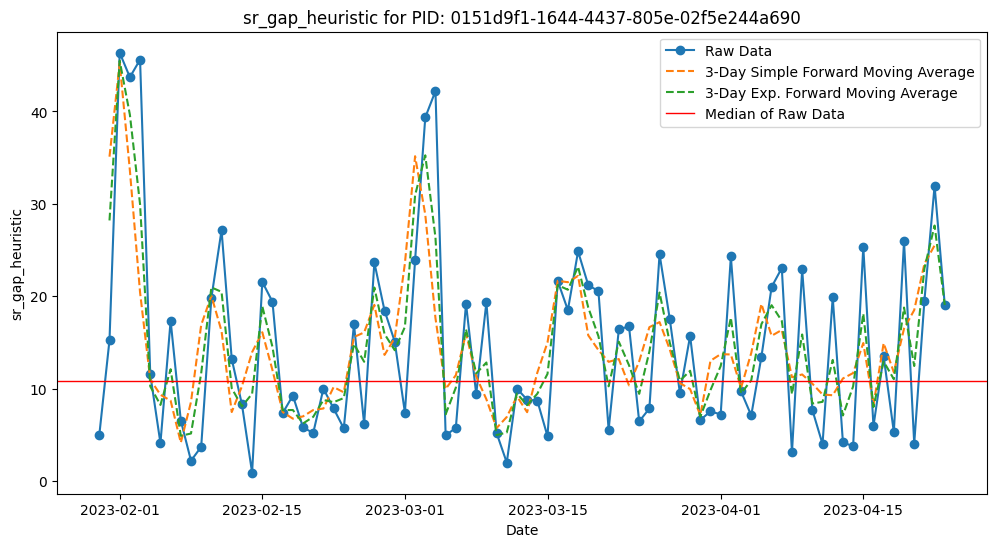

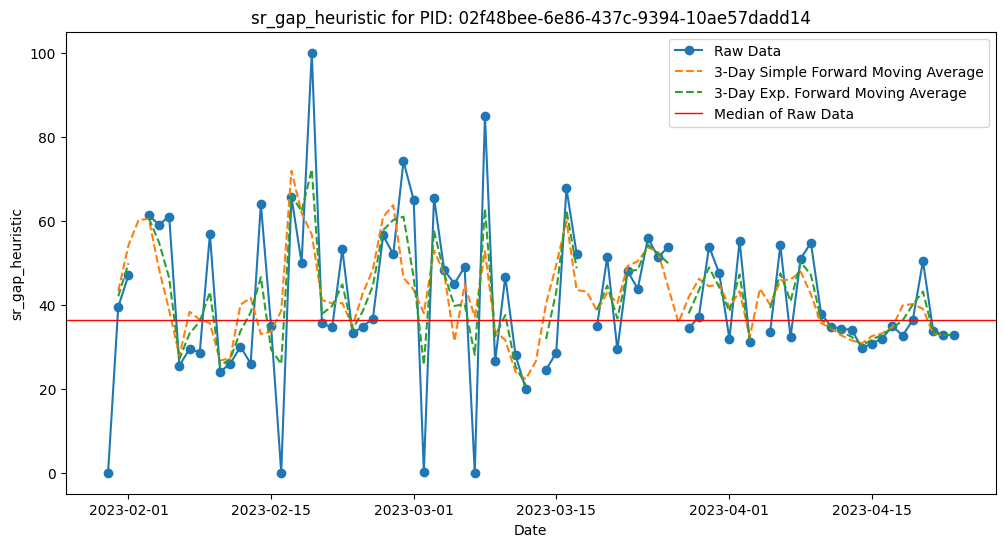

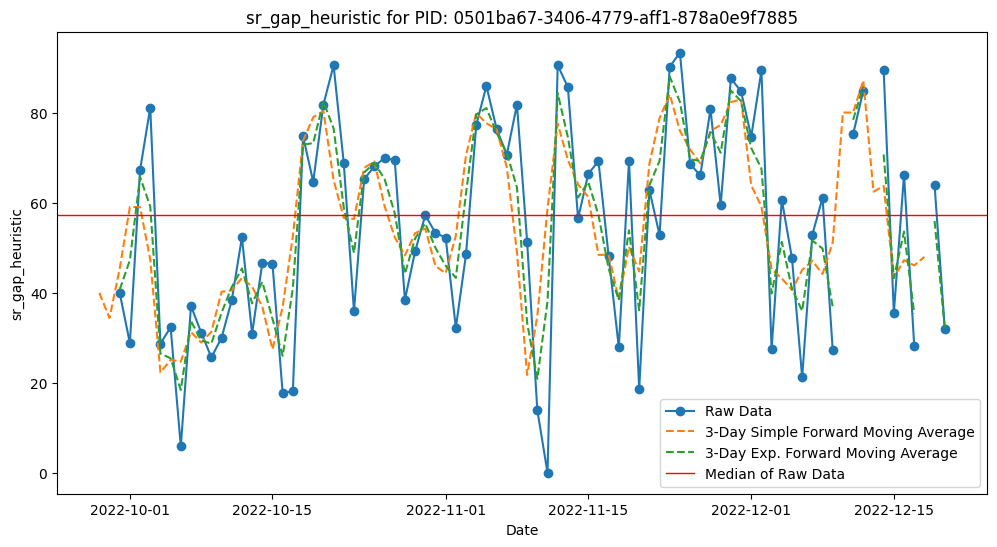

In [11]:
# Visualize a couple subjects with both original and three day smoothed gap

# This is not the same as the target as it is the average of [current day, cd+1, cd+2]
# The target column created is the average of [cd+1, cd+2, cd+3]

# Selecting two PIDs
pids = target_df['PID'].unique()[:3]

# Filter the dataframe for the two PIDs
df_filtered = target_df[target_df['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic', 't_next3', 't_next3e']]

# Ensure the trial_date is in datetime format
df_filtered['trial_date'] = pd.to_datetime(df_filtered['trial_date'])

# Sort by trial_date for each PID
df_filtered = df_filtered.sort_values(by=['PID', 'trial_date'])

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['t_next3'].shift(1), label='3-Day Simple Forward Moving Average', linestyle='--')
    plt.plot(df_pid['trial_date'], df_pid['t_next3e'].shift(1), label='3-Day Exp. Forward Moving Average', linestyle='--')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='red', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()